## Modeling and Conclusion

Having cleaned and explore the posts from both r/PremierLeague and r/championsleague, we will now process, train and evaluate several models which would be able to classify whether readers' comments is related to Champions' League or Premier League.

### Import the libraries

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords, wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import pos_tag

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier

from datetime import datetime




In [2]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
pd.options.display.max_colwidth=500

### Import the combined dataset

In [3]:
df_sub = pd.read_csv('../data/df_sub.csv')

In [4]:
df_sub.drop(columns=['created_utc', 'post_hint'], inplace=True)

### Process the posts

We will proceed to tokenize the posts to keep only words in the text using `RegexTokenizer`, convert them to all lower case and use `pos_tag` to tag each token with its corresponding part-of-speech. We will then create and use a custom function `get_wordnet_pos` which enables tokens that are not nouns to be correctly tagged for lemmatization later.

In [5]:
def get_wordnet_pos(tag):
    
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

The following custom function executes all the above-mentioned processing step and join the tokens back as strings

In [6]:
def process_posts(post):
    reg_tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    post = reg_tokenizer.tokenize(post)
    post = [x.lower() for x in post]
    post = pos_tag(post)
    post = [(x[0], get_wordnet_pos(x[1])) for x in post]
    
    lemmatizer = WordNetLemmatizer()
    post = [lemmatizer.lemmatize(x[0], x[1]) for x in post]
    return ' '.join(post)

We will now apply the `process_posts` function on `selftext`

In [7]:
df_sub['selftext'] = df_sub['selftext'].map(process_posts)

In [8]:
df_sub.head()

,selftext,championsleague
0,in the european championship it be difficult to predict but what be the strong club that have the potential accord to the opinion of bayern munich chelsea man city real madrid psg man united liverpool atletico madrid barcelona inter milan villarreal juventos write your expectation in the comment and if there be a club i do not add it i be sorry but we all have different opinion i hope that you will write the expectation frankly not because of your love for the club what be the most clubs com...,1
1,uefa champion league ajax besiktas match info date september time utc venue johan cruijff arena odds bookmaker home draw away bwin nordicbet bet william hill bet marathonbet unibet betsson bet pinnacle sbo xbet sportingbet betway tipico betcris sport dafabet head to head date result competition team statistic ajax home away all game play win draws loss goal goal for goal against goal average goal for goal against besiktas home away all game play win draws loss goal goal for goal against goal...,1
2,if pep guardiola s barcelona from face hansi flick s bayern munich from who would win would the german do another or will the spanish get the best of the german view poll pep guardiola s barcelona v hansi flick s bayern munich who would win,1
3,hi i m aware that psg and bayern be both favorite to win the cl along with man city but i just have this feeling that psg may or may not win it they have messi mbappe and ramos to name a few a formidable squad bayern though have lewandowski muller and kimmich who be basically the top player in the world for their respective position plus come to look at bundesliga match i m see bayern thrash opponent psg be fare very well too but something tell me that the final s gonna be lewandowski v mess...,1
4,manchester unite face off against young boy in the first game of the champion league on tuesday and be the first team to lose in the competition this season a brutal loss in a game that they deserve to go home with atleast a point however a costly error in the die second of the game be all that those young boy need to secure the first win of the competition cast our mind back however they re be a surprising number of positive you can observe from the game if you be a manchester united fan li...,1


### Split the data into train and test sets

In [9]:
X = df_sub['selftext']
y = df_sub['championsleague']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.2,
                                                    stratify=y)

### Training of Models

We will now train several and compare their accuracy score

#### Establish the baseline score

To establish the baseline accuracy score, we assume a model that predicts the posts is Champions' League related 100% of the time: 

In [10]:
df_sub['championsleague'].value_counts(normalize=True)

0    0.503377
1    0.496623
Name: championsleague, dtype: float64

#### Establish a list of `stop_words`

In [11]:
stop_words = list(CountVectorizer(stop_words='english').get_stop_words()) + ['to', 'you', 
              'the', 'and', 'in', 'is', 'my', 'me', 'it', 'for', 'your',
              'of', 'that', 'have', 'on', 'now', 'are', 'so', 'can', 'epl', 'pl', 'ucl'
              'champion', 'premier', 'league', 'cl','this', 'be', 'they', 'but', 'will',
              'all', 'if', 'who', 'or', 'by', 'he', 'not', 'what', 'from', 'would', 'like',
              'with', 'at', 'wa','do', 'their', 'get', 'ha', 'just', 'one', 'no', 'we', 'off',
              'there', 'know', 'how', 'about', 'up', 'against', 'been', 'an', 'his', 'more',
              'which', 'most', 'them', 'any', 'last', 'why', 'some', 'could', 'only', 'should',
              'don', 'had', 'after', 'when', 'where', 'back', 'make', 've', 'also', 'other', 
              'very', 'really', 'here', 'even', 'am', 'were', 'into', 'being', 'because', 'than',
              'yet', 'anyone', 'go', 'championsleague', 'premierleague', 'vs', 'match', 'shots',
              'goal', 'game', 'think', 'season', 'amp','city', 'manchester', 'liverpool', 
              'yellow', 'card', 'discord', 'poll']

#### Fit a Multinomial Naive Bayes Model with Bag of Words

In [12]:
#Create Pipeline
pipe_cvec_nb = Pipeline([
    ('cvec', CountVectorizer(stop_words = stop_words)),
    ('nb', MultinomialNB())    
])

In [13]:
#Parameters to gridsearch over
pipe_cvec_nb_params = {
        'cvec__max_features' : [1000, 2000, 3000, 4000, 5000],    
        'cvec__ngram_range' : [(1,1), (1,2)],
}

In [14]:
gs_cvec_nb = GridSearchCV(
    pipe_cvec_nb,
    param_grid = pipe_cvec_nb_params,
    cv=5
)

In [15]:
gs_cvec_nb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['amount',
                                                                    'whatever',
                                                                    'mill',
                                                                    'though',
                                                                    'other',
                                                                    'almost',
                                                                    'over',
                                                                    'noone',
                                                                    'if',
                                                                    'another',
                                                                    'name',
                                                                    'indeed',
      

In [16]:
gs_cvec_nb.best_params_

{'cvec__max_features': 1000, 'cvec__ngram_range': (1, 1)}

In [17]:
gs_cvec_nb.best_score_

0.8623376623376622

In [18]:
gs_cvec_nb.score(X_test, y_test)

0.8727272727272727

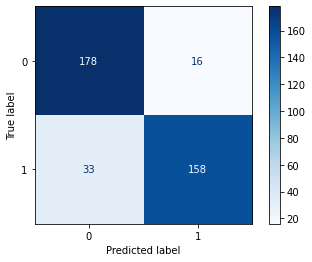

In [19]:
plot_confusion_matrix(gs_cvec_nb, X_test, y_test, cmap='Blues', values_format='d');

**Features Analysis**

We will now use difference in `features_log_prob_` to identify words which contribute to predicting r/championsleague posts over r/PremierLeague posts

In [20]:
#Access MultinomialNB in the pipeline and calculate the difference in features_log_prob
nb_clf = gs_cvec_nb.best_estimator_.named_steps['nb']
log_prob_difference = nb_clf.feature_log_prob_[1] - nb_clf.feature_log_prob_[0]

In [21]:
log_prob_difference = nb_clf.feature_log_prob_[1] - nb_clf.feature_log_prob_[0]

In [22]:
#Create a DataFrame of words and their corresponding log_porb_diff
d = {'word': gs_cvec_nb.best_estimator_.named_steps['cvec'].get_feature_names(),
     'log_prob_diff': log_prob_difference
    }

df_features = pd.DataFrame(data=d)

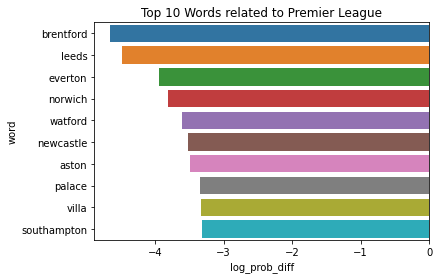

In [23]:
words_impt = df_features.sort_values(by='log_prob_diff')
words_impt

sns.barplot(y='word', x='log_prob_diff', data=words_impt.head(10))
plt.title('Top 10 Words related to Premier League');

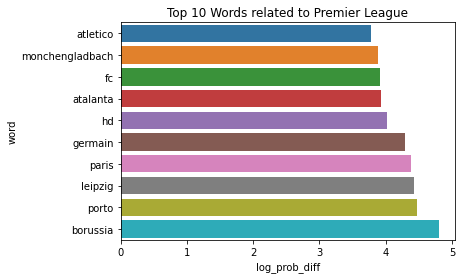

In [24]:
sns.barplot(y='word', x='log_prob_diff', data=words_impt.tail(10))
plt.title('Top 10 Words related to Premier League');

**Key Observation**

1. Words with negative `log_prob_diff` are those that has highest log probability in r/PremierLeague subreddit compared with r/championsleague. It is clear that names of English clubs (Brentford, Leeds, Everton) that participate in the Premier League but not the Champions League dmoninates this word list

2. Conversely, words with positive `log_prob_diff` are those that has highest log probability in r/PremierLeague subreddit compared with r/championsleague. This list consists mostly of names of non-English European Clubs (Borussia, Porto, Leipzig etc) that is participating in the competition

**Misclassification Analysis**

We will now evaluate those posts that were misclassified (False Positives and False Negatives)

In [25]:
y_preds = gs_cvec_nb.predict(X_test)

In [26]:
df_misclass = pd.DataFrame(data = {'y_test': y_test, 'y_preds': y_preds})

misclass_idx_fp = df_misclass[((df_misclass['y_test']==0)&(df_misclass['y_preds']==1))].index

misclass_idx_fn = df_misclass[((df_misclass['y_test']==1)&(df_misclass['y_preds']==0))].index

In [27]:
df_sub[df_sub.index.isin(misclass_idx_fn)]

,selftext,championsleague
4,manchester unite face off against young boy in the first game of the champion league on tuesday and be the first team to lose in the competition this season a brutal loss in a game that they deserve to go home with atleast a point however a costly error in the die second of the game be all that those young boy need to secure the first win of the competition cast our mind back however they re be a surprising number of positive you can observe from the game if you be a manchester united fan li...,1
38,view poll a a neutral what be the best game to watch today,1
50,do anybody remember when sky one do a special about year ago and show the great champion league goal be there any way i can watch that again i have it record but lose it a while ago i would pay a significant amount of money to watch it again great champion league goal sky one,1
77,vol,1
94,what make you think he be a good tactician pep guardiola,1
96,let me know your view why do t silva get substituted look at the reply not sure if he have a major injury,1
103,remove view poll man city or chelsea,1
132,so the top automatically qualify for the cl in the premier league with chelsea and city in the cl final as well a in the top their spot for win it would be pass down to th place in the pl unite could win the el and gain an extra cl spot but they re in the top a well will their cl spot go to th place if they win chelsea play leicester in the fa cup which have a place in the el they ll both be in the cl so that spot could then be pass down to th a th would already be an automatic spot the conf...,1
133,i m a west ham fan look to follow a european team in the champion league help me pick don t care which league they come from originally but look for a team that s similar in play style and attitude to the iron equivalence of team,1
136,view poll who do you want in your side,1


In [28]:
df_sub[df_sub.index.isin(misclass_idx_fp)]

,selftext,championsleague
1020,hi guy do you know any english speaking radio to follow primer league match in live i mean when they be comment the match sorry for my english and thanks in advance radio to follow premier league match in live,0
1043,chelsea be already make their presence know in the premier league a they sit top of the table head into this weekend s fixtures man city provide the opposition on saturday lunchtime and give the recent result between the two club guardiola have plenty to be concern about this weekend chelsea draw no bet we re back chelsea with a draw no bet meaning that if the home side win the bet pay out but if the game be to end in a draw then we would get our stake back chelsea have win four of their las...,0
1047,i need to know for fantasy purpose lol but also a a pl fanin all actuality will jam rodriguez see a pl start before his move to rayan,0
1094,on the right side of the screen there be three dot click that and you will see change user flair click that and pick your flair then click apply for anyone want a user flair the little badge and stuff beside your username heres how,0
1117,liverpool and chelsea look like they could go all the way and if all their stats be the same by the end of the season accord to some source we would get a premier league final at wembley it s super rare because they would have to have the same goal difference goal score goal concede and would have to draw against each other again we ve see crazy thing happen do you think we could get a premier league final this year,0
1126,england get literally world class player at rb spot where any of them would arguably be a first choice a a rb for almost any nation do you remember any other nation with so big first world problem ever be england nt rb spot get best ever coverage in international football ever,0
1198,uefa champion league group stage ns manchester city rb leipzig match info date september time utc venue etihad stadium referee s g z b y k recent form manchester city rb leipzig lineup manchester city no lineup available yet start xi substitute coach rb leipzig no lineup available yet start xi substitute coach match stats amp x b manchester city rb leipzig shot on goal shot off goal shot inside box shot outside box total shot block shot fouls corner kick offsides ball possession yellow card ...,0
1199,uefa champion league group stage ns liverpool ac milan match info date september time utc venue anfield referee s marciniak recent form liverpool ac milan lineups liverpool no lineup available yet start xi substitute coach ac milan no lineup available yet start xi substitute coach match stats amp x b liverpool ac milan shot on goal shot off goal shot inside box shot outside box total shot block shot fouls corner kick offsides ball possession yellow card red card goalkeeper save total pass pa...,0
1208,join my new fantasy hub mini champion league enter pin free mobile app league fantasy football,0
1271,hey guy i be plan to purchase subscription to watch match i be reside in the u and would love to be a part of a plan with member screen also do you guy know about any cheap subscription to purchase online if i would be the only one in that plan i be use totalsportek to watch match but i think it time for me to switch to a proper streaming platform watch match on which platform,0


**Key Observation**

There are a few types of post that gets misclassified:

1. Some posts talks about the Champions League in a Premier League subreddit and vice-versa which leads to misclassification
2. Some posts were not specifically talking about the Premier League or Champions League, but rather were general questions on how to watch streams of football using vpn without paying for services from official providers

CountVectorizer merely uses the frequency of a word, but not the word's importance to one document, relative to other documents. We will now fit a Multinomial Baive Bayes model with Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer

#### Fit a Multinomial Naive Bayes Model with TF-IDF

In [29]:
pipe_tvec_nb = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = stop_words)),
    ('nb', MultinomialNB())    
])

In [30]:
pipe_tvec_nb_params = {
        'tvec__max_features' : [1000, 2000, 3000, 4000, 5000],    
        'tvec__ngram_range' : [(1,1), (1,2)],
}

In [31]:
gs_tvec_nb = GridSearchCV(
    pipe_tvec_nb,
    param_grid = pipe_tvec_nb_params,
    cv=5
)

In [32]:
gs_tvec_nb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['amount',
                                                                    'whatever',
                                                                    'mill',
                                                                    'though',
                                                                    'other',
                                                                    'almost',
                                                                    'over',
                                                                    'noone',
                                                                    'if',
                                                                    'another',
                                                                    'name',
                                                                    'indeed',
      

In [33]:
gs_tvec_nb.best_params_

{'tvec__max_features': 1000, 'tvec__ngram_range': (1, 1)}

In [34]:
gs_tvec_nb.best_score_

0.8733766233766234

In [35]:
gs_tvec_nb.score(X_test, y_test)

0.8779220779220779

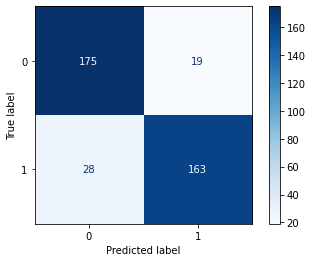

In [36]:
plot_confusion_matrix(gs_tvec_nb, X_test, y_test, cmap='Blues', values_format='d');

**Features Analysis**

We will now use difference in `features_log_prob_` to identify words which contribute to predicting r/championsleague posts over r/PremierLeague posts

In [37]:
#Access MultinomialNB in the pipeline and calculate the difference in features_log_prob
nb_clf = gs_tvec_nb.best_estimator_.named_steps['nb']
log_prob_difference = nb_clf.feature_log_prob_[1] - nb_clf.feature_log_prob_[0]

In [38]:
log_prob_difference = nb_clf.feature_log_prob_[1] - nb_clf.feature_log_prob_[0]

In [39]:
#Create a DataFrame of words and their corresponding log_porb_diff
d = {'word': gs_tvec_nb.best_estimator_.named_steps['tvec'].get_feature_names(),
     'log_prob_diff': log_prob_difference
    }

df_features = pd.DataFrame(data=d)

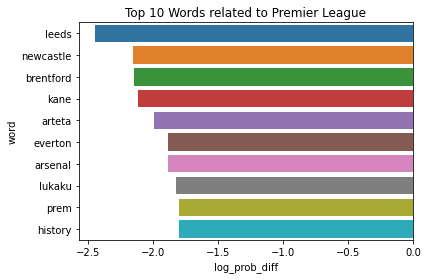

In [40]:
words_impt = df_features.sort_values(by='log_prob_diff')
words_impt
sns.barplot(y='word', x='log_prob_diff', data=words_impt.head(10))
plt.title('Top 10 Words related to Premier League');

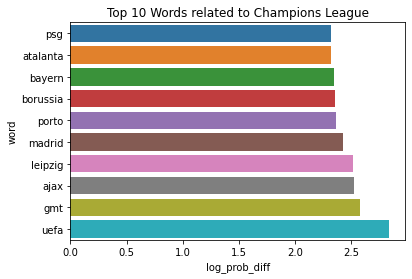

In [41]:
sns.barplot(y='word', x='log_prob_diff', data=words_impt.tail(10))
plt.title('Top 10 Words related to Champions League');

**Key Observation**

There were some changes in feature importance at both extremes compared to using Bag of words, but the general theme remain the same: English club names are important features for predicting a Premier League subreddit and European clubs for Champions League

**Misclassification Analysis**

We will now evaluate those posts that were misclassified (False Positives and False Negatives)

In [42]:
y_preds = gs_tvec_nb.predict(X_test)

In [43]:
df_misclass = pd.DataFrame(data = {'y_test': y_test, 'y_preds': y_preds})

misclass_idx_fp = df_misclass[((df_misclass['y_test']==0)&(df_misclass['y_preds']==1))].index

misclass_idx_fn = df_misclass[((df_misclass['y_test']==1)&(df_misclass['y_preds']==0))].index

In [44]:
df_sub[df_sub.index.isin(misclass_idx_fn)]

,selftext,championsleague
4,manchester unite face off against young boy in the first game of the champion league on tuesday and be the first team to lose in the competition this season a brutal loss in a game that they deserve to go home with atleast a point however a costly error in the die second of the game be all that those young boy need to secure the first win of the competition cast our mind back however they re be a surprising number of positive you can observe from the game if you be a manchester united fan li...,1
38,view poll a a neutral what be the best game to watch today,1
50,do anybody remember when sky one do a special about year ago and show the great champion league goal be there any way i can watch that again i have it record but lose it a while ago i would pay a significant amount of money to watch it again great champion league goal sky one,1
77,vol,1
89,anyone notice the guy leave man city and be now a champion league winner beat man citywilly caballero,1
94,what make you think he be a good tactician pep guardiola,1
96,let me know your view why do t silva get substituted look at the reply not sure if he have a major injury,1
103,remove view poll man city or chelsea,1
133,i m a west ham fan look to follow a european team in the champion league help me pick don t care which league they come from originally but look for a team that s similar in play style and attitude to the iron equivalence of team,1
136,view poll who do you want in your side,1


In [45]:
df_sub[df_sub.index.isin(misclass_idx_fp)]

,selftext,championsleague
1014,their home kit be light blue and away be white if they didn t wear the away one against a blue kit team chelsea when be they ever gonna wear it why do man city wear their home kit today,0
1020,hi guy do you know any english speaking radio to follow primer league match in live i mean when they be comment the match sorry for my english and thanks in advance radio to follow premier league match in live,0
1043,chelsea be already make their presence know in the premier league a they sit top of the table head into this weekend s fixtures man city provide the opposition on saturday lunchtime and give the recent result between the two club guardiola have plenty to be concern about this weekend chelsea draw no bet we re back chelsea with a draw no bet meaning that if the home side win the bet pay out but if the game be to end in a draw then we would get our stake back chelsea have win four of their las...,0
1047,i need to know for fantasy purpose lol but also a a pl fanin all actuality will jam rodriguez see a pl start before his move to rayan,0
1094,on the right side of the screen there be three dot click that and you will see change user flair click that and pick your flair then click apply for anyone want a user flair the little badge and stuff beside your username heres how,0
1117,liverpool and chelsea look like they could go all the way and if all their stats be the same by the end of the season accord to some source we would get a premier league final at wembley it s super rare because they would have to have the same goal difference goal score goal concede and would have to draw against each other again we ve see crazy thing happen do you think we could get a premier league final this year,0
1126,england get literally world class player at rb spot where any of them would arguably be a first choice a a rb for almost any nation do you remember any other nation with so big first world problem ever be england nt rb spot get best ever coverage in international football ever,0
1198,uefa champion league group stage ns manchester city rb leipzig match info date september time utc venue etihad stadium referee s g z b y k recent form manchester city rb leipzig lineup manchester city no lineup available yet start xi substitute coach rb leipzig no lineup available yet start xi substitute coach match stats amp x b manchester city rb leipzig shot on goal shot off goal shot inside box shot outside box total shot block shot fouls corner kick offsides ball possession yellow card ...,0
1199,uefa champion league group stage ns liverpool ac milan match info date september time utc venue anfield referee s marciniak recent form liverpool ac milan lineups liverpool no lineup available yet start xi substitute coach ac milan no lineup available yet start xi substitute coach match stats amp x b liverpool ac milan shot on goal shot off goal shot inside box shot outside box total shot block shot fouls corner kick offsides ball possession yellow card red card goalkeeper save total pass pa...,0
1208,join my new fantasy hub mini champion league enter pin free mobile app league fantasy football,0


**Multinomial Naive Bayes Models Summary**

| Models | Description                         | Hyperparams                                            | Train Accuracy | Test Accuracy |
|--------|-------------------------------------|--------------------------------------------------------|----------------|---------------|
| 1      | CVec with Multinomial Naive Bayes   | cvec__max_features: 1000,  cvec__ngram_range: (1, 1)   | 0.862          | 0.872         |
| 2      | TF-IDF with Multinomial Naive Bayes | tvec__max_features: 1000,  tvec__ngram_range: (1, 1)   | 0.873          | 0.878         |

**Key Observation**

TF-IDF with Multinomial Naive Bayes model managed to reduce the number of r/championsleague posts incorrectly predicted as r/PremierLeague from 38 to 28(False Negative). However, the number of r/PremierLeague posts incorrectly predicted as r/championsleague increase from 14 to 18 (False Negative). Overall, the accuracy score on the test set increases from 0.868 using bag of words to 0.881 using tf-idf

#### Fit a Logistic Regression with l2 Penalization Model with Bag of Words

In [46]:
pipe_cvec_lr_l2 = Pipeline([
    ('cvec', CountVectorizer(stop_words = stop_words)),
    ('lr', LogisticRegression())    
])

In [47]:
pipe_cvec_lr_l2_params = {
        'cvec__max_features':[1000, 2000, 3000, 4000, 5000],    
        'cvec__ngram_range':[(1,1), (1,2)],
        'lr__C':[0.001, 0.01, 0.1, 1, 10, 100],
        'lr__penalty':['l2'],
        'lr__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'lr__max_iter' : [200]
}

In [48]:
gs_cvec_lr_l2 = GridSearchCV(
    pipe_cvec_lr_l2,
    param_grid = pipe_cvec_lr_l2_params,
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [49]:
gs_cvec_lr_l2.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['amount',
                                                                    'whatever',
                                                                    'mill',
                                                                    'though',
                                                                    'other',
                                                                    'almost',
                                                                    'over',
                                                                    'noone',
                                                                    'if',
                                                                    'another',
                                                                    'name',
                                                                    'indeed',
      

In [50]:
gs_cvec_lr_l2.best_params_

{'cvec__max_features': 1000,
 'cvec__ngram_range': (1, 2),
 'lr__C': 0.1,
 'lr__max_iter': 200,
 'lr__penalty': 'l2',
 'lr__solver': 'newton-cg'}

In [51]:
gs_cvec_lr_l2.best_score_

0.8779220779220779

In [52]:
gs_cvec_lr_l2.score(X_test, y_test)

0.8779220779220779

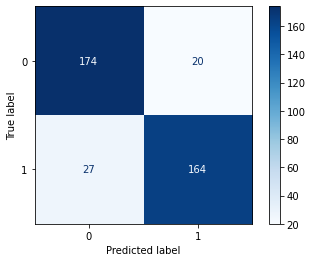

In [53]:
plot_confusion_matrix(gs_cvec_lr_l2, X_test, y_test, cmap='Blues', values_format='d');

**Features Analysis**

We will use the coefficients of the logistics regression to identify words which contribute to predicting r/championsleague posts over r/PremierLeague posts

In [54]:
lr_l2_clf = gs_cvec_lr_l2.best_estimator_.named_steps['lr']

In [55]:
lr_l2_coef = pd.DataFrame(lr_l2_clf.coef_.flatten(), 
                          index = gs_cvec_lr_l2.best_estimator_.named_steps['cvec'].get_feature_names(), 
                          columns=['Coefficient']
                         ).sort_values(by='Coefficient', ascending=False)

In [56]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", 100)
pd.options.display.max_colwidth=500
lr_l2_coef

,Coefficient
champion,9.910567e-01
final,7.470229e-01
psg,7.428373e-01
uefa,6.836161e-01
ucl,6.490999e-01
gmt,5.740457e-01
bayern,5.322993e-01
stream,5.186010e-01
barcelona,5.007857e-01
view,4.902186e-01


**Misclassification Analysis**

We will now evaluate those posts that were misclassified (False Positives and False Negatives)

In [57]:
y_preds = gs_cvec_lr_l2.predict(X_test)

In [58]:
df_misclass = pd.DataFrame(data = {'y_test': y_test, 'y_preds': y_preds})

misclass_idx_fp = df_misclass[((df_misclass['y_test']==0)&(df_misclass['y_preds']==1))].index

misclass_idx_fn = df_misclass[((df_misclass['y_test']==1)&(df_misclass['y_preds']==0))].index

In [59]:
df_sub[df_sub.index.isin(misclass_idx_fn)]

,selftext,championsleague
4,manchester unite face off against young boy in the first game of the champion league on tuesday and be the first team to lose in the competition this season a brutal loss in a game that they deserve to go home with atleast a point however a costly error in the die second of the game be all that those young boy need to secure the first win of the competition cast our mind back however they re be a surprising number of positive you can observe from the game if you be a manchester united fan li...,1
41,post your rant and complaint about the match in hereyb v mun rant post,1
94,what make you think he be a good tactician pep guardiola,1
103,remove view poll man city or chelsea,1
105,what be some good site for streamingstreaming manchester city v chelsea,1
133,i m a west ham fan look to follow a european team in the champion league help me pick don t care which league they come from originally but look for a team that s similar in play style and attitude to the iron equivalence of team,1
178,if your be read this please accept my apology for any incorrect english expression a i be not a native english speak person i will just try to speak my mind and tough about the super league problem and what uefa need to to do fix it first let talk about the problem why the so called big club need this super league the economical mistake that kinda force them to try to get even more revenew out of the football industry premier league top club and italian spanish top club be live above their s...,1
318,remove view poll which of these team be the most likely to win,1
345,chat about the draw here unless a mod post a watch along then chat on that onedraw watch along,1
378,i remember man have some crazy win streak at anfield and can t remember i time he s lose at home before this be it true be this the first time man lose at anfield,1


In [60]:
df_sub[df_sub.index.isin(misclass_idx_fp)]

,selftext,championsleague
1014,their home kit be light blue and away be white if they didn t wear the away one against a blue kit team chelsea when be they ever gonna wear it why do man city wear their home kit today,0
1020,hi guy do you know any english speaking radio to follow primer league match in live i mean when they be comment the match sorry for my english and thanks in advance radio to follow premier league match in live,0
1047,i need to know for fantasy purpose lol but also a a pl fanin all actuality will jam rodriguez see a pl start before his move to rayan,0
1084,amp x b argue with city fan,0
1094,on the right side of the screen there be three dot click that and you will see change user flair click that and pick your flair then click apply for anyone want a user flair the little badge and stuff beside your username heres how,0
1117,liverpool and chelsea look like they could go all the way and if all their stats be the same by the end of the season accord to some source we would get a premier league final at wembley it s super rare because they would have to have the same goal difference goal score goal concede and would have to draw against each other again we ve see crazy thing happen do you think we could get a premier league final this year,0
1198,uefa champion league group stage ns manchester city rb leipzig match info date september time utc venue etihad stadium referee s g z b y k recent form manchester city rb leipzig lineup manchester city no lineup available yet start xi substitute coach rb leipzig no lineup available yet start xi substitute coach match stats amp x b manchester city rb leipzig shot on goal shot off goal shot inside box shot outside box total shot block shot fouls corner kick offsides ball possession yellow card ...,0
1199,uefa champion league group stage ns liverpool ac milan match info date september time utc venue anfield referee s marciniak recent form liverpool ac milan lineups liverpool no lineup available yet start xi substitute coach ac milan no lineup available yet start xi substitute coach match stats amp x b liverpool ac milan shot on goal shot off goal shot inside box shot outside box total shot block shot fouls corner kick offsides ball possession yellow card red card goalkeeper save total pass pa...,0
1208,join my new fantasy hub mini champion league enter pin free mobile app league fantasy football,0
1348,hi guy i be plan to catch a few premier league game and possibly a champion league game in the uk this fall covid permit where s the best place to get ticket or should i just buy at the stadium feedbacks comment and advises be appreciate premier league ticket,0


#### Fit a Logistic Regression with l2 Penalization Model with TF-IDF

In [61]:
pipe_tvec_lr_l2 = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = stop_words)),
    ('lr', LogisticRegression())    
])

In [62]:
pipe_tvec_lr_l2_params = {
        'tvec__max_features':[1000, 2000, 3000, 4000, 5000],    
        'tvec__ngram_range':[(1,1), (1,2)],
        'lr__C':[0.001, 0.01, 0.1, 1, 10, 100],
        'lr__penalty':['l2'],
        'lr__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'lr__max_iter' : [200]
}

In [63]:
gs_tvec_lr_l2 = GridSearchCV(
    pipe_tvec_lr_l2,
    param_grid = pipe_tvec_lr_l2_params,
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [64]:
gs_tvec_lr_l2.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['amount',
                                                                    'whatever',
                                                                    'mill',
                                                                    'though',
                                                                    'other',
                                                                    'almost',
                                                                    'over',
                                                                    'noone',
                                                                    'if',
                                                                    'another',
                                                                    'name',
                                                                    'indeed',
      

In [65]:
gs_tvec_lr_l2.best_params_

{'lr__C': 10,
 'lr__max_iter': 200,
 'lr__penalty': 'l2',
 'lr__solver': 'saga',
 'tvec__max_features': 3000,
 'tvec__ngram_range': (1, 2)}

In [66]:
gs_tvec_lr_l2.best_score_

0.8837662337662338

In [67]:
gs_tvec_lr_l2.score(X_test, y_test)

0.8623376623376623

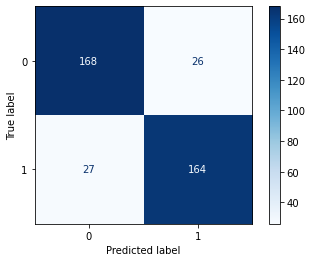

In [68]:
plot_confusion_matrix(gs_tvec_lr_l2, X_test, y_test, cmap='Blues', values_format='d');

**Features Analysis**

We will use the coefficients of the logistics regression to identify words which contribute to predicting r/championsleague posts over r/PremierLeague posts

In [69]:
lr_l2_clf = gs_tvec_lr_l2.best_estimator_.named_steps['lr']

In [70]:
lr_l2_coef = pd.DataFrame(lr_l2_clf.coef_.flatten(), 
                          index = gs_tvec_lr_l2.best_estimator_.named_steps['tvec'].get_feature_names(), 
                          columns=['Coefficient']
                         ).sort_values(by='Coefficient', ascending=False)

In [71]:
lr_l2_coef

,Coefficient
champion,7.368951
view,5.694292
final,5.580055
psg,5.343392
ucl,5.042380
uefa,5.008374
gmt,4.312968
leipzig,4.205474
bayern,4.162834
barcelona,3.997571


**Misclassification Analysis**

We will now evaluate those posts that were misclassified (False Positives and False Negatives)

In [72]:
y_preds = gs_tvec_lr_l2.predict(X_test)

In [73]:
df_misclass = pd.DataFrame(data = {'y_test': y_test, 'y_preds': y_preds})

misclass_idx_fp = df_misclass[((df_misclass['y_test']==0)&(df_misclass['y_preds']==1))].index

misclass_idx_fn = df_misclass[((df_misclass['y_test']==1)&(df_misclass['y_preds']==0))].index

In [74]:
df_sub[df_sub.index.isin(misclass_idx_fn)]

,selftext,championsleague
4,manchester unite face off against young boy in the first game of the champion league on tuesday and be the first team to lose in the competition this season a brutal loss in a game that they deserve to go home with atleast a point however a costly error in the die second of the game be all that those young boy need to secure the first win of the competition cast our mind back however they re be a surprising number of positive you can observe from the game if you be a manchester united fan li...,1
41,post your rant and complaint about the match in hereyb v mun rant post,1
50,do anybody remember when sky one do a special about year ago and show the great champion league goal be there any way i can watch that again i have it record but lose it a while ago i would pay a significant amount of money to watch it again great champion league goal sky one,1
94,what make you think he be a good tactician pep guardiola,1
103,remove view poll man city or chelsea,1
133,i m a west ham fan look to follow a european team in the champion league help me pick don t care which league they come from originally but look for a team that s similar in play style and attitude to the iron equivalence of team,1
140,who do you think would win the trophy and why both team have formidable defense the best cam vs the best cdm i can t think of a favorite among the two team they re both so balance would be an interesting final comment your thought final preview,1
291,i couldn t fit all the team but here be some that i think be contestant of course all of them be but here be just view poll who will win the cl this year,1
318,remove view poll which of these team be the most likely to win,1
319,perisic son b silva guerreiro saul kimmich florenzi alaba fabhino marquinhos ederson can play in every formation you think be best sub who could be in your starformation cancelo milner can isco say why think they can can t win champion league and what the weak link be and when you want post your start formation they all have a good chem and your manager choicewould this team be able to win the champion league,1


In [75]:
df_sub[df_sub.index.isin(misclass_idx_fp)]

,selftext,championsleague
1014,their home kit be light blue and away be white if they didn t wear the away one against a blue kit team chelsea when be they ever gonna wear it why do man city wear their home kit today,0
1020,hi guy do you know any english speaking radio to follow primer league match in live i mean when they be comment the match sorry for my english and thanks in advance radio to follow premier league match in live,0
1047,i need to know for fantasy purpose lol but also a a pl fanin all actuality will jam rodriguez see a pl start before his move to rayan,0
1094,on the right side of the screen there be three dot click that and you will see change user flair click that and pick your flair then click apply for anyone want a user flair the little badge and stuff beside your username heres how,0
1117,liverpool and chelsea look like they could go all the way and if all their stats be the same by the end of the season accord to some source we would get a premier league final at wembley it s super rare because they would have to have the same goal difference goal score goal concede and would have to draw against each other again we ve see crazy thing happen do you think we could get a premier league final this year,0
1126,england get literally world class player at rb spot where any of them would arguably be a first choice a a rb for almost any nation do you remember any other nation with so big first world problem ever be england nt rb spot get best ever coverage in international football ever,0
1197,i m work on a creative project but i m no english native so i d like to have some reference regard what be some of the most widely use or the most popular song from chant in england it can be use by just one team and be very popular or use by many team with different lyric thank a lot in advancewhat be the most common popular song use in english team chant,0
1198,uefa champion league group stage ns manchester city rb leipzig match info date september time utc venue etihad stadium referee s g z b y k recent form manchester city rb leipzig lineup manchester city no lineup available yet start xi substitute coach rb leipzig no lineup available yet start xi substitute coach match stats amp x b manchester city rb leipzig shot on goal shot off goal shot inside box shot outside box total shot block shot fouls corner kick offsides ball possession yellow card ...,0
1199,uefa champion league group stage ns liverpool ac milan match info date september time utc venue anfield referee s marciniak recent form liverpool ac milan lineups liverpool no lineup available yet start xi substitute coach ac milan no lineup available yet start xi substitute coach match stats amp x b liverpool ac milan shot on goal shot off goal shot inside box shot outside box total shot block shot fouls corner kick offsides ball possession yellow card red card goalkeeper save total pass pa...,0
1208,join my new fantasy hub mini champion league enter pin free mobile app league fantasy football,0


**Logistic Regression with L2 Penalization Models Summary**

| Models | Description           | Hyperparams                                                                                                                    | Train Accuracy | Test Accuracy |
|--------|-----------------------|--------------------------------------------------------------------------------------------------------------------------------|----------------|---------------|
| 1      | CVec with LogReg L2   | cvec__max_features: 1000, cvec__ngram_range: (1, 2), lr__C: 0.1, lr__max_iter: 200, lr__penalty: 'l2', lr__solver: 'newton-cg' | 0.878          | 0.878         |
| 2      | TF-IDF with LogReg L2 | lr__C: 10, lr__max_iter: 200, lr__penalty: 'l2', lr__solver: 'saga', tvec__max_features: 3000, tvec__ngram_range: (1, 2)       | 0.884          | 0.862         |

**Key Observation on both `cvec_lr_l2` and `tvec_lr_l2` models**
1. There was no real difference in model accuracy between the Bag of Words and TF-IDF. The l2 regularization may have played a part in ironing out any significant difference in features weights.
2. Both models did slightly worse than TF-IDF with Multinomial Naive Bayes but slightly better than Bag of Words with 
Multinomial Naive Bayes
3. The best parameter chosen by the gridsearch for `ngram_range` was a combination of unigram and bigrams. This introduce a few word features which contain the full name of the club (e.g. real madrid), but otherwise the most inmportant features remains the name of clubs, although we are also seeing players name (kane, salah) coming into the influential word list. 

#### Fit a Logistic Regression with l1 Penalization Model with Bag of Words

In [76]:
pipe_cvec_lr_l1 = Pipeline([
    ('cvec', CountVectorizer(stop_words = stop_words)),
    ('lr', LogisticRegression())    
])

In [77]:
pipe_cvec_lr_l1_params = {
        'cvec__max_features':[1000, 2000, 3000, 4000, 5000],    
        'cvec__ngram_range':[(1,1), (1,2)],
        'lr__C':[0.001, 0.01, 0.1, 1, 10, 100],
        'lr__penalty':['l1'],
        'lr__solver':['liblinear', 'saga'],
        'lr__max_iter' : [200]
}

In [78]:
gs_cvec_lr_l1 = GridSearchCV(
    pipe_cvec_lr_l1,
    param_grid = pipe_cvec_lr_l1_params,
    cv=5,
    verbose=1
)

In [79]:
gs_cvec_lr_l1.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/sit

/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/sit

/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/sit

/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/sit

/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/sit

/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/sit

/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['amount',
                                                                    'whatever',
                                                                    'mill',
                                                                    'though',
                                                                    'other',
                                                                    'almost',
                                                                    'over',
                                                                    'noone',
                                                                    'if',
                                                                    'another',
                                                                    'name',
                                                                    'indeed',
      

In [80]:
gs_cvec_lr_l1.best_params_

{'cvec__max_features': 2000,
 'cvec__ngram_range': (1, 1),
 'lr__C': 10,
 'lr__max_iter': 200,
 'lr__penalty': 'l1',
 'lr__solver': 'saga'}

In [81]:
gs_cvec_lr_l1.best_score_

0.8714285714285713

In [82]:
gs_cvec_lr_l1.score(X_test, y_test)

0.8753246753246753

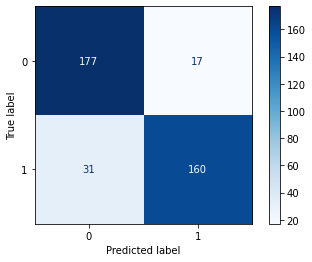

In [83]:
plot_confusion_matrix(gs_cvec_lr_l1, X_test, y_test, cmap='Blues', values_format='d');

**Features Analysis**

We will use the coefficients of the logistics regression to identify words which contribute to predicting r/championsleague posts over r/PremierLeague posts

In [84]:
lr_l1_clf = gs_cvec_lr_l1.best_estimator_.named_steps['lr']

In [85]:
lr_l1_coef = pd.DataFrame(lr_l1_clf.coef_.flatten(), 
                          index = gs_cvec_lr_l1.best_estimator_.named_steps['cvec'].get_feature_names(), 
                          columns=['Coefficient']
                         ).sort_values(by='Coefficient', ascending=False)

In [86]:
lr_l1_coef

,Coefficient
champion,1.081651e+00
final,7.853869e-01
uefa,6.671691e-01
psg,6.495701e-01
ucl,5.641736e-01
madrid,5.626505e-01
bayern,5.533413e-01
stream,5.330094e-01
barcelona,4.772489e-01
gmt,4.406062e-01


**Misclassification Analysis**

We will now evaluate those posts that were misclassified (False Positives and False Negatives)

In [87]:
y_preds = gs_cvec_lr_l1.predict(X_test)

In [88]:
df_misclass = pd.DataFrame(data = {'y_test': y_test, 'y_preds': y_preds})

misclass_idx_fp = df_misclass[((df_misclass['y_test']==0)&(df_misclass['y_preds']==1))].index

misclass_idx_fn = df_misclass[((df_misclass['y_test']==1)&(df_misclass['y_preds']==0))].index

In [89]:
df_sub[df_sub.index.isin(misclass_idx_fn)]

,selftext,championsleague
4,manchester unite face off against young boy in the first game of the champion league on tuesday and be the first team to lose in the competition this season a brutal loss in a game that they deserve to go home with atleast a point however a costly error in the die second of the game be all that those young boy need to secure the first win of the competition cast our mind back however they re be a surprising number of positive you can observe from the game if you be a manchester united fan li...,1
38,view poll a a neutral what be the best game to watch today,1
94,what make you think he be a good tactician pep guardiola,1
103,remove view poll man city or chelsea,1
105,what be some good site for streamingstreaming manchester city v chelsea,1
133,i m a west ham fan look to follow a european team in the champion league help me pick don t care which league they come from originally but look for a team that s similar in play style and attitude to the iron equivalence of team,1
136,view poll who do you want in your side,1
139,i think chelsea will win view poll who do you think will win,1
178,if your be read this please accept my apology for any incorrect english expression a i be not a native english speak person i will just try to speak my mind and tough about the super league problem and what uefa need to to do fix it first let talk about the problem why the so called big club need this super league the economical mistake that kinda force them to try to get even more revenew out of the football industry premier league top club and italian spanish top club be live above their s...,1
291,i couldn t fit all the team but here be some that i think be contestant of course all of them be but here be just view poll who will win the cl this year,1


In [90]:
df_sub[df_sub.index.isin(misclass_idx_fp)]

,selftext,championsleague
1014,their home kit be light blue and away be white if they didn t wear the away one against a blue kit team chelsea when be they ever gonna wear it why do man city wear their home kit today,0
1020,hi guy do you know any english speaking radio to follow primer league match in live i mean when they be comment the match sorry for my english and thanks in advance radio to follow premier league match in live,0
1047,i need to know for fantasy purpose lol but also a a pl fanin all actuality will jam rodriguez see a pl start before his move to rayan,0
1094,on the right side of the screen there be three dot click that and you will see change user flair click that and pick your flair then click apply for anyone want a user flair the little badge and stuff beside your username heres how,0
1117,liverpool and chelsea look like they could go all the way and if all their stats be the same by the end of the season accord to some source we would get a premier league final at wembley it s super rare because they would have to have the same goal difference goal score goal concede and would have to draw against each other again we ve see crazy thing happen do you think we could get a premier league final this year,0
1198,uefa champion league group stage ns manchester city rb leipzig match info date september time utc venue etihad stadium referee s g z b y k recent form manchester city rb leipzig lineup manchester city no lineup available yet start xi substitute coach rb leipzig no lineup available yet start xi substitute coach match stats amp x b manchester city rb leipzig shot on goal shot off goal shot inside box shot outside box total shot block shot fouls corner kick offsides ball possession yellow card ...,0
1199,uefa champion league group stage ns liverpool ac milan match info date september time utc venue anfield referee s marciniak recent form liverpool ac milan lineups liverpool no lineup available yet start xi substitute coach ac milan no lineup available yet start xi substitute coach match stats amp x b liverpool ac milan shot on goal shot off goal shot inside box shot outside box total shot block shot fouls corner kick offsides ball possession yellow card red card goalkeeper save total pass pa...,0
1208,join my new fantasy hub mini champion league enter pin free mobile app league fantasy football,0
1348,hi guy i be plan to catch a few premier league game and possibly a champion league game in the uk this fall covid permit where s the best place to get ticket or should i just buy at the stadium feedbacks comment and advises be appreciate premier league ticket,0
1448,why be there no game mid week at the moment then all of a sudden they start cram the champion league fa etc why why why no game mid week at the moment,0


#### Fit a Logistic Regression with l1 Penalization Model with TF-IDF

In [91]:
pipe_tvec_lr_l1 = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = stop_words)),
    ('lr', LogisticRegression())    
])

In [92]:
pipe_tvec_lr_l1_params = {
        'tvec__max_features':[1000, 2000, 3000, 4000, 5000],    
        'tvec__ngram_range':[(1,1), (1,2)],
        'lr__C':[0.001, 0.01, 0.1, 1, 10, 100],
        'lr__penalty':['l1'],
        'lr__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'lr__max_iter' : [200]
}

In [93]:
gs_tvec_lr_l1 = GridSearchCV(
    pipe_tvec_lr_l1,
    param_grid = pipe_tvec_lr_l1_params,
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [94]:
gs_tvec_lr_l1.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


/Users/Shared/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.50324675 0.50324675 0.50324675 0.50324675
 0.50324675 0.50324675 0.50324675 0.50324675 0.50324675 0.50324675
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.50194805 0.49935065
 0.50194805 0.50064935 0.50194805 0.49805195 0.50194805 0.50064935
 0.49935065 0.50194805        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.50324675 0.50324675
 0.50324675 0.50324675 0.50324675

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['amount',
                                                                    'whatever',
                                                                    'mill',
                                                                    'though',
                                                                    'other',
                                                                    'almost',
                                                                    'over',
                                                                    'noone',
                                                                    'if',
                                                                    'another',
                                                                    'name',
                                                                    'indeed',
      

In [95]:
gs_tvec_lr_l1.best_params_

{'lr__C': 100,
 'lr__max_iter': 200,
 'lr__penalty': 'l1',
 'lr__solver': 'saga',
 'tvec__max_features': 5000,
 'tvec__ngram_range': (1, 2)}

In [96]:
gs_tvec_lr_l1.best_score_

0.8707792207792208

In [97]:
gs_tvec_lr_l1.score(X_test, y_test)

0.8597402597402597

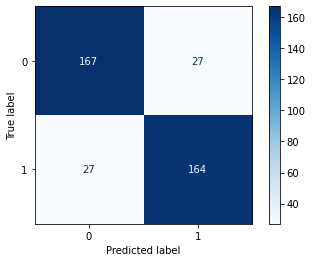

In [98]:
plot_confusion_matrix(gs_tvec_lr_l1, X_test, y_test, cmap='Blues', values_format='d');

**Features Analysis**

We will use the coefficients of the logistics regression to identify words which contribute to predicting r/championsleague posts over r/PremierLeague posts

In [99]:
lr_l1_clf = gs_tvec_lr_l1.best_estimator_.named_steps['lr']

In [100]:
lr_l1_coef = pd.DataFrame(lr_l1_clf.coef_.flatten(), 
                          index = gs_tvec_lr_l1.best_estimator_.named_steps['tvec'].get_feature_names(), 
                          columns=['Coefficient']
                         ).sort_values(by='Coefficient', ascending=False)

In [101]:
lr_l1_coef

,Coefficient
champion,21.295895
view,16.907179
uefa,16.799666
psg,15.936020
ucl,15.396828
gmt,15.325993
final,14.186987
leipzig,13.316817
tournament,12.753879
canada,12.089546


**Misclassification Analysis**

We will now evaluate those posts that were misclassified (False Positives and False Negatives)

In [102]:
y_preds = gs_cvec_lr_l1.predict(X_test)

In [103]:
df_misclass = pd.DataFrame(data = {'y_test': y_test, 'y_preds': y_preds})

misclass_idx_fp = df_misclass[((df_misclass['y_test']==0)&(df_misclass['y_preds']==1))].index

misclass_idx_fn = df_misclass[((df_misclass['y_test']==1)&(df_misclass['y_preds']==0))].index

In [104]:
df_sub[df_sub.index.isin(misclass_idx_fn)]

,selftext,championsleague
4,manchester unite face off against young boy in the first game of the champion league on tuesday and be the first team to lose in the competition this season a brutal loss in a game that they deserve to go home with atleast a point however a costly error in the die second of the game be all that those young boy need to secure the first win of the competition cast our mind back however they re be a surprising number of positive you can observe from the game if you be a manchester united fan li...,1
38,view poll a a neutral what be the best game to watch today,1
94,what make you think he be a good tactician pep guardiola,1
103,remove view poll man city or chelsea,1
105,what be some good site for streamingstreaming manchester city v chelsea,1
133,i m a west ham fan look to follow a european team in the champion league help me pick don t care which league they come from originally but look for a team that s similar in play style and attitude to the iron equivalence of team,1
136,view poll who do you want in your side,1
139,i think chelsea will win view poll who do you think will win,1
178,if your be read this please accept my apology for any incorrect english expression a i be not a native english speak person i will just try to speak my mind and tough about the super league problem and what uefa need to to do fix it first let talk about the problem why the so called big club need this super league the economical mistake that kinda force them to try to get even more revenew out of the football industry premier league top club and italian spanish top club be live above their s...,1
291,i couldn t fit all the team but here be some that i think be contestant of course all of them be but here be just view poll who will win the cl this year,1


In [105]:
df_sub[df_sub.index.isin(misclass_idx_fp)]

,selftext,championsleague
1014,their home kit be light blue and away be white if they didn t wear the away one against a blue kit team chelsea when be they ever gonna wear it why do man city wear their home kit today,0
1020,hi guy do you know any english speaking radio to follow primer league match in live i mean when they be comment the match sorry for my english and thanks in advance radio to follow premier league match in live,0
1047,i need to know for fantasy purpose lol but also a a pl fanin all actuality will jam rodriguez see a pl start before his move to rayan,0
1094,on the right side of the screen there be three dot click that and you will see change user flair click that and pick your flair then click apply for anyone want a user flair the little badge and stuff beside your username heres how,0
1117,liverpool and chelsea look like they could go all the way and if all their stats be the same by the end of the season accord to some source we would get a premier league final at wembley it s super rare because they would have to have the same goal difference goal score goal concede and would have to draw against each other again we ve see crazy thing happen do you think we could get a premier league final this year,0
1198,uefa champion league group stage ns manchester city rb leipzig match info date september time utc venue etihad stadium referee s g z b y k recent form manchester city rb leipzig lineup manchester city no lineup available yet start xi substitute coach rb leipzig no lineup available yet start xi substitute coach match stats amp x b manchester city rb leipzig shot on goal shot off goal shot inside box shot outside box total shot block shot fouls corner kick offsides ball possession yellow card ...,0
1199,uefa champion league group stage ns liverpool ac milan match info date september time utc venue anfield referee s marciniak recent form liverpool ac milan lineups liverpool no lineup available yet start xi substitute coach ac milan no lineup available yet start xi substitute coach match stats amp x b liverpool ac milan shot on goal shot off goal shot inside box shot outside box total shot block shot fouls corner kick offsides ball possession yellow card red card goalkeeper save total pass pa...,0
1208,join my new fantasy hub mini champion league enter pin free mobile app league fantasy football,0
1348,hi guy i be plan to catch a few premier league game and possibly a champion league game in the uk this fall covid permit where s the best place to get ticket or should i just buy at the stadium feedbacks comment and advises be appreciate premier league ticket,0
1448,why be there no game mid week at the moment then all of a sudden they start cram the champion league fa etc why why why no game mid week at the moment,0


**Logistic Regression with L1 Penalization Models Summary**

| Models | Description           | Hyperparams                                                                                                                   | Train Accuracy | Test Accuracy |
|--------|-----------------------|-------------------------------------------------------------------------------------------------------------------------------|----------------|---------------|
| 1      | CVec with LogReg L1   | cvec__max_features: 2000, cvec__ngram_range: (1, 1), lr__C: 10, lr__max_iter: 200, lr__penalty: 'l1', lr__solver: 'saga'       | 0.871          | 0.875         |
| 2      | TF-IDF with LogReg L1 | lr__C: 100, lr__max_iter: 200,  lr__penalty: 'l1',  lr__solver: 'saga',  tvec__max_features: 5000,  tvec__ngram_range: (1, 2) | 0.871          | 0.860         |

**Key Observation on both `cvec_lr_l1` and `tvec_lr_l1` models**
1. TF-IDF did slightly worse than Bag of Word. The l1 regularization shuts off the coefficient of certain word features more aggressively

2. Words with high positive coefficient are mainly names of European clubs while those with high negative coefficients are mostly names of English clubs which does not take part in Champions League

#### Fit a Random Forest Model with Bag of Words

In [134]:
pipe_cvec_rf = Pipeline([
    ('cvec', CountVectorizer(stop_words = stop_words)),
    ('rf', RandomForestClassifier())    
])

In [135]:
pipe_cvec_rf_params = {
        'cvec__max_features':[1000, 2000, 3000],    
        'cvec__ngram_range':[(1,1), (1,2)],
        'rf__n_estimators': [100, 150, 200],
        'rf__max_depth': [10, 11, 12, None],
        'rf__min_samples_split' : [5, 10, 15],
        'rf__min_samples_leaf' : [2, 3, 4],
        'rf__ccp_alpha' : [0, 0.1, 1, 10] 
}

In [136]:
gs_cvec_rf = GridSearchCV(
    pipe_cvec_rf,
    param_grid = pipe_cvec_rf_params,
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [137]:
gs_cvec_rf.fit(X_train, y_train)

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['amount',
                                                                    'whatever',
                                                                    'mill',
                                                                    'though',
                                                                    'other',
                                                                    'almost',
                                                                    'over',
                                                                    'noone',
                                                                    'if',
                                                                    'another',
                                                                    'name',
                                                                    'indeed',
      

In [138]:
gs_cvec_rf.best_params_

{'cvec__max_features': 3000,
 'cvec__ngram_range': (1, 1),
 'rf__ccp_alpha': 0,
 'rf__max_depth': None,
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 10,
 'rf__n_estimators': 100}

In [139]:
gs_cvec_rf.best_score_

0.8727272727272727

In [140]:
gs_cvec_rf.score(X_test, y_test)

0.8857142857142857

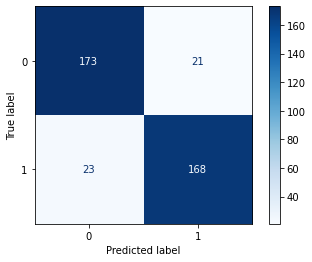

In [141]:
plot_confusion_matrix(gs_cvec_rf, X_test, y_test, cmap='Blues', values_format='d');

**Features Analysis**

We will use the `feature_importances_` of the random forest to identify words which contribute the most to decreasing gini impurity

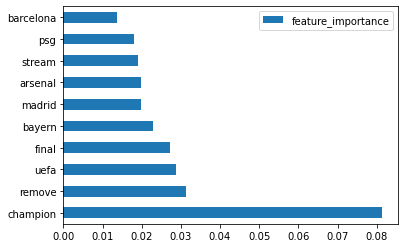

In [142]:
rf_clf = gs_cvec_rf.best_estimator_.named_steps['rf']
rf_features = pd.DataFrame(rf_clf.feature_importances_, 
                          index = gs_cvec_rf.best_estimator_.named_steps['cvec'].get_feature_names(), 
                          columns=['feature_importance']
                          ).sort_values(by='feature_importance', ascending=False)

rf_features.head(10).plot(kind='barh');

In [143]:
#what was the avergae depth of each tree?
np.mean([estimator.tree_.max_depth for estimator in rf_clf.estimators_])

68.48

**Misclassification Analysis**

We will now evaluate those posts that were misclassified (False Positives and False Negatives)

In [144]:
y_preds = gs_cvec_rf.predict(X_test)

In [145]:
df_misclass = pd.DataFrame(data = {'y_test': y_test, 'y_preds': y_preds})

misclass_idx_fp = df_misclass[((df_misclass['y_test']==0)&(df_misclass['y_preds']==1))].index

misclass_idx_fn = df_misclass[((df_misclass['y_test']==1)&(df_misclass['y_preds']==0))].index

In [146]:
df_sub[df_sub.index.isin(misclass_idx_fn)]

,selftext,championsleague
4,manchester unite face off against young boy in the first game of the champion league on tuesday and be the first team to lose in the competition this season a brutal loss in a game that they deserve to go home with atleast a point however a costly error in the die second of the game be all that those young boy need to secure the first win of the competition cast our mind back however they re be a surprising number of positive you can observe from the game if you be a manchester united fan li...,1
94,what make you think he be a good tactician pep guardiola,1
103,remove view poll man city or chelsea,1
105,what be some good site for streamingstreaming manchester city v chelsea,1
291,i couldn t fit all the team but here be some that i think be contestant of course all of them be but here be just view poll who will win the cl this year,1
318,remove view poll which of these team be the most likely to win,1
375,what do you all think manchester united paris v saint germain,1
378,i remember man have some crazy win streak at anfield and can t remember i time he s lose at home before this be it true be this the first time man lose at anfield,1
391,remove view poll who be go to the uel in the group b,1
410,many european club reportedly in negotiation about form an team european premier league back by fifa consisting of the top team from england spain germany italy and france thought new league,1


In [147]:
df_sub[df_sub.index.isin(misclass_idx_fp)]

,selftext,championsleague
1020,hi guy do you know any english speaking radio to follow primer league match in live i mean when they be comment the match sorry for my english and thanks in advance radio to follow premier league match in live,0
1043,chelsea be already make their presence know in the premier league a they sit top of the table head into this weekend s fixtures man city provide the opposition on saturday lunchtime and give the recent result between the two club guardiola have plenty to be concern about this weekend chelsea draw no bet we re back chelsea with a draw no bet meaning that if the home side win the bet pay out but if the game be to end in a draw then we would get our stake back chelsea have win four of their las...,0
1047,i need to know for fantasy purpose lol but also a a pl fanin all actuality will jam rodriguez see a pl start before his move to rayan,0
1094,on the right side of the screen there be three dot click that and you will see change user flair click that and pick your flair then click apply for anyone want a user flair the little badge and stuff beside your username heres how,0
1117,liverpool and chelsea look like they could go all the way and if all their stats be the same by the end of the season accord to some source we would get a premier league final at wembley it s super rare because they would have to have the same goal difference goal score goal concede and would have to draw against each other again we ve see crazy thing happen do you think we could get a premier league final this year,0
1186,if a winger cross the ball into the and be turn in for an own goal do the assist count for the winger goal score assist,0
1198,uefa champion league group stage ns manchester city rb leipzig match info date september time utc venue etihad stadium referee s g z b y k recent form manchester city rb leipzig lineup manchester city no lineup available yet start xi substitute coach rb leipzig no lineup available yet start xi substitute coach match stats amp x b manchester city rb leipzig shot on goal shot off goal shot inside box shot outside box total shot block shot fouls corner kick offsides ball possession yellow card ...,0
1199,uefa champion league group stage ns liverpool ac milan match info date september time utc venue anfield referee s marciniak recent form liverpool ac milan lineups liverpool no lineup available yet start xi substitute coach ac milan no lineup available yet start xi substitute coach match stats amp x b liverpool ac milan shot on goal shot off goal shot inside box shot outside box total shot block shot fouls corner kick offsides ball possession yellow card red card goalkeeper save total pass pa...,0
1208,join my new fantasy hub mini champion league enter pin free mobile app league fantasy football,0
1271,hey guy i be plan to purchase subscription to watch match i be reside in the u and would love to be a part of a plan with member screen also do you guy know about any cheap subscription to purchase online if i would be the only one in that plan i be use totalsportek to watch match but i think it time for me to switch to a proper streaming platform watch match on which platform,0


#### Fit a Random Forest Model with TF-IDF

In [148]:
pipe_tvec_rf = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = stop_words)),
    ('rf', RandomForestClassifier())    
])

In [149]:
pipe_tvec_rf_params = {
        'tvec__max_features':[1000, 2000, 3000],    
        'tvec__ngram_range':[(1,1), (1,2)],
        'rf__n_estimators': [100, 150, 200],
        'rf__max_depth': [10, 11, 12, None],
        'rf__min_samples_split' : [5, 10, 15],
        'rf__min_samples_leaf' : [2, 3, 4],
        'rf__ccp_alpha' : [0, 0.1, 1, 10] 
}

In [150]:
gs_tvec_rf = GridSearchCV(
    pipe_tvec_rf,
    param_grid = pipe_tvec_rf_params,
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [151]:
gs_tvec_rf.fit(X_train, y_train)

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['amount',
                                                                    'whatever',
                                                                    'mill',
                                                                    'though',
                                                                    'other',
                                                                    'almost',
                                                                    'over',
                                                                    'noone',
                                                                    'if',
                                                                    'another',
                                                                    'name',
                                                                    'indeed',
      

In [152]:
gs_tvec_rf.best_params_

{'rf__ccp_alpha': 0,
 'rf__max_depth': None,
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 5,
 'rf__n_estimators': 150,
 'tvec__max_features': 3000,
 'tvec__ngram_range': (1, 1)}

In [153]:
gs_tvec_rf.best_score_

0.8694805194805195

In [154]:
gs_tvec_rf.score(X_test, y_test)

0.8857142857142857

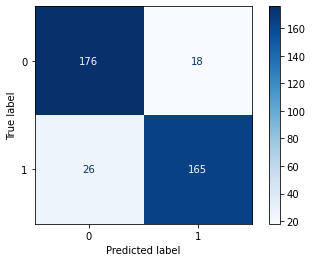

In [155]:
plot_confusion_matrix(gs_tvec_rf, X_test, y_test, cmap='Blues', values_format='d');

**Features Analysis**

We will use the `feature_importances_` of the random forest to identify words which contribute the most to decreasing gini impurity

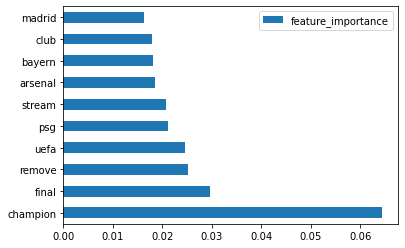

In [156]:
rf_clf = gs_tvec_rf.best_estimator_.named_steps['rf']
rf_features = pd.DataFrame(rf_clf.feature_importances_, 
                          index = gs_tvec_rf.best_estimator_.named_steps['tvec'].get_feature_names(), 
                          columns=['feature_importance']
                          ).sort_values(by='feature_importance', ascending=False)

rf_features.head(10).plot(kind='barh');

In [157]:
#what was the average depth of each tree?
np.mean([estimator.tree_.max_depth for estimator in rf_clf.estimators_])

74.66

**Misclassification Analysis**

We will now evaluate those posts that were misclassified (False Positives and False Negatives)

In [158]:
y_preds = gs_tvec_rf.predict(X_test)

In [159]:
df_misclass = pd.DataFrame(data = {'y_test': y_test, 'y_preds': y_preds})

misclass_idx_fp = df_misclass[((df_misclass['y_test']==0)&(df_misclass['y_preds']==1))].index

misclass_idx_fn = df_misclass[((df_misclass['y_test']==1)&(df_misclass['y_preds']==0))].index

In [160]:
df_sub[df_sub.index.isin(misclass_idx_fn)]

,selftext,championsleague
4,manchester unite face off against young boy in the first game of the champion league on tuesday and be the first team to lose in the competition this season a brutal loss in a game that they deserve to go home with atleast a point however a costly error in the die second of the game be all that those young boy need to secure the first win of the competition cast our mind back however they re be a surprising number of positive you can observe from the game if you be a manchester united fan li...,1
94,what make you think he be a good tactician pep guardiola,1
103,remove view poll man city or chelsea,1
105,what be some good site for streamingstreaming manchester city v chelsea,1
132,so the top automatically qualify for the cl in the premier league with chelsea and city in the cl final as well a in the top their spot for win it would be pass down to th place in the pl unite could win the el and gain an extra cl spot but they re in the top a well will their cl spot go to th place if they win chelsea play leicester in the fa cup which have a place in the el they ll both be in the cl so that spot could then be pass down to th a th would already be an automatic spot the conf...,1
133,i m a west ham fan look to follow a european team in the champion league help me pick don t care which league they come from originally but look for a team that s similar in play style and attitude to the iron equivalence of team,1
291,i couldn t fit all the team but here be some that i think be contestant of course all of them be but here be just view poll who will win the cl this year,1
318,remove view poll which of these team be the most likely to win,1
375,what do you all think manchester united paris v saint germain,1
378,i remember man have some crazy win streak at anfield and can t remember i time he s lose at home before this be it true be this the first time man lose at anfield,1


In [161]:
df_sub[df_sub.index.isin(misclass_idx_fp)]

,selftext,championsleague
1020,hi guy do you know any english speaking radio to follow primer league match in live i mean when they be comment the match sorry for my english and thanks in advance radio to follow premier league match in live,0
1043,chelsea be already make their presence know in the premier league a they sit top of the table head into this weekend s fixtures man city provide the opposition on saturday lunchtime and give the recent result between the two club guardiola have plenty to be concern about this weekend chelsea draw no bet we re back chelsea with a draw no bet meaning that if the home side win the bet pay out but if the game be to end in a draw then we would get our stake back chelsea have win four of their las...,0
1047,i need to know for fantasy purpose lol but also a a pl fanin all actuality will jam rodriguez see a pl start before his move to rayan,0
1094,on the right side of the screen there be three dot click that and you will see change user flair click that and pick your flair then click apply for anyone want a user flair the little badge and stuff beside your username heres how,0
1117,liverpool and chelsea look like they could go all the way and if all their stats be the same by the end of the season accord to some source we would get a premier league final at wembley it s super rare because they would have to have the same goal difference goal score goal concede and would have to draw against each other again we ve see crazy thing happen do you think we could get a premier league final this year,0
1198,uefa champion league group stage ns manchester city rb leipzig match info date september time utc venue etihad stadium referee s g z b y k recent form manchester city rb leipzig lineup manchester city no lineup available yet start xi substitute coach rb leipzig no lineup available yet start xi substitute coach match stats amp x b manchester city rb leipzig shot on goal shot off goal shot inside box shot outside box total shot block shot fouls corner kick offsides ball possession yellow card ...,0
1199,uefa champion league group stage ns liverpool ac milan match info date september time utc venue anfield referee s marciniak recent form liverpool ac milan lineups liverpool no lineup available yet start xi substitute coach ac milan no lineup available yet start xi substitute coach match stats amp x b liverpool ac milan shot on goal shot off goal shot inside box shot outside box total shot block shot fouls corner kick offsides ball possession yellow card red card goalkeeper save total pass pa...,0
1208,join my new fantasy hub mini champion league enter pin free mobile app league fantasy football,0
1348,hi guy i be plan to catch a few premier league game and possibly a champion league game in the uk this fall covid permit where s the best place to get ticket or should i just buy at the stadium feedbacks comment and advises be appreciate premier league ticket,0
1448,why be there no game mid week at the moment then all of a sudden they start cram the champion league fa etc why why why no game mid week at the moment,0


**Random Forest Models Summary**

| Models | Description               | Hyperparams                                                                                                                                                           | Train Accuracy | Test Accuracy |
|--------|---------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------|---------------|
| 1      | CVec with Random Forest   | cvec__max_features: 3000, cvec__ngram_range: (1, 1), rf__ccp_alpha: 0, rf__max_depth: None, rf__min_samples_leaf: 2, rf__min_samples_split: 10, rf__n_estimators: 100 | 0.873          | 0.885         |
| 2      | TF-IDF with Random Forest | rf__ccp_alpha: 0, rf__max_depth: None, rf__min_samples_leaf: 2, rf__min_samples_split: 5, rf__n_estimators: 150, tvec__max_features: 3000, tvec__ngram_range: (1, 1) | 0.869           | 0.885         |

**Key Observation on both `gs_cvec_rf` and `gs_tvec_rf` models**
1. There was no real difference in model accuracy between the Bag of Words and TF-IDF model of Random Forest. 

2. The top words for features importance distinguishes the Champions League and the Premier League. For example, the word 'final' tends to be associated with Champions League.

3. Many of the misclassified posts for the Random Forest models, especially those predicted as Premier League posts when it is a Champions League post, were very short and do not contain enough influential words.

### Conclusion and Recommendation

The following summarizes the best models trained and their performance:

| Models | Description                         | Hyperparams                                                                                                                                                           | Train Accuracy | Test Accuracy |
|--------|-------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------|---------------|
| 1      | TF-IDF with Multinomial Naive Bayes | tvec__max_features: 1000,  tvec__ngram_range: (1, 1)                                                                                                                  | 0.873          | 0.878         |
| 2      | CVec with LogReg L2   | cvec__max_features: 1000, cvec__ngram_range: (1, 2), lr__C: 0.1, lr__max_iter: 200, lr__penalty: 'l2', lr__solver: 'newton-cg' | 0.878          | 0.878         |
| 3      | CVec with LogReg L1   | cvec__max_features: 2000, cvec__ngram_range: (1, 1), lr__C: 10, lr__max_iter: 200, lr__penalty: 'l1', lr__solver: 'saga'       | 0.871          | 0.875         |
| 4      | CVec with Random Forest   | cvec__max_features: 3000, cvec__ngram_range: (1, 1), rf__ccp_alpha: 0, rf__max_depth: None, rf__min_samples_leaf: 2, rf__min_samples_split: 10, rf__n_estimators: 100 | 0.873          | 0.885         |

The CountVectorizer with RandomForest is the best performing model.  One of the advantages of RandomForest over algorithms which work on the assumption that classes can be separated by a straight line (e.g.Logistic Regression) is that it can handle high dimensional and complex data structures.

Some word features is related exclusively to champions league and the premier league respectively. These words are usually club names or player names and appears in the important features of all four models that were trained.

It was observed that during the training of both RandomForest models, choosing to gridsearch over specific `max_depth` reduced the accuracy of the models. The gridsearch eventually selected `max_depth` as `None`. Theoretically, allowing the RandomForest unrestricted depth may lead to overfitting. The average depth of the fitted models were around 70 to 75. Empirically, however, there was no overfitting of the training set when compared to the test set. A plausible explanation is that RandomForest algorithm splits the tree using a subset of trees for each bootstrap, this itself is a defence mechanism against overfitting which reduces the effect of depth.

The misclassified posts typically falls into the following categories:

1. The post was too short to contain any significant influential words for the model to make a correct prediction

2. The post was talking about the Champions League in a Premier League subreddit and vice-versa.

3. The content of the posts had nothing to do with the subreddit. This happens quite frequently when users ask about links for pirated football match streams or vpns to watch streams outside of their country.

There is clearly room for improvement for the EuroFootball Data Science team to further improve the performance of the classifier model. The following are suggested actions to improve the models:

1. Further scraped posts from subreddit needs to be reviewed to ensure they are free from the above mentioned type of posts before they are used to train the models. 

2. Comments should be scraped from another football website (e.g the Athletic) where high quality football journalism foster discussion and not about sharing video clips.